In [1]:
%load_ext line_profiler
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset,TensorDataset
# from utils import *

from foolbox.models import PyTorchModel
from foolbox.attacks import BoundaryAttack

In [2]:
class Args:
    def __init__(self):
        self.embed_num = 128
        self.embed_dim = 5
        self.class_num = 2
        self.kernel_num = 100
        self.kernel_sizes = [3,5,7,9]
        #self.dropout = 0.3
        self.static = True
        
class CNN_Text_dropout(nn.Module):
    
    def __init__(self, args):
        super(CNN_Text_dropout, self).__init__()
        self.args = args
        
        V = args.embed_num
        D = args.embed_dim
        C = args.class_num
        Ci = 1
        Co = args.kernel_num
        Ks = args.kernel_sizes

        #self.embed = nn.Embedding(V, D)
        # self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels=Ci, out_channels=Co, kernel_size=(K, D),stride=1) for K in Ks])
        
        #self.dropout = nn.Dropout(args.dropout)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(Ks)*Co, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, C)
        self.relu = nn.ReLU()
        
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def weight_init(self):
        for module in self.convs1:
            torch.nn.init.xavier_uniform_(module.weight)
            torch.nn.init.constant_(module.bias, 0.1)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.constant_(self.fc1.bias, 0.1)

    def forward(self, x):

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        self.features = x
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.dropout3(x)
        logit = self.fc3(x)
        #print('in the FP')
        #print(x.shape)
        #logit = self.fc3(self.relu(self.fc2()))
        return logit

In [3]:
X_train=np.load("./Data/sGrid/X_train.npy")
X_test=np.load("./Data/sGrid/X_test.npy")
X_vaild=np.load("./Data/sGrid/X_vaild.npy")
Y_train=np.load("./Data/sGrid/Y_train.npy")
Y_test=np.load("./Data/sGrid/Y_test.npy")
Y_vaild=np.load("./Data/sGrid/Y_vaild.npy")

torch.manual_seed(1)
embedding = nn.Embedding(128, 5, max_norm = 1)

Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)
Y_vaild = torch.from_numpy(Y_vaild)

input = Variable(torch.from_numpy(X_train*128).long())
X_train_embed = embedding(input)
X_train_embed = X_train_embed.detach()

input = Variable(torch.from_numpy(X_test*128).long())
X_test_embed = embedding(input)
X_test_embed = X_test_embed.detach()

input = Variable(torch.from_numpy(X_vaild*128).long())
X_vaild_embed = embedding(input)
X_vaild_embed = X_vaild_embed.detach()

dic = {}
count = 0
for i in range(X_train.shape[0]):
    for j in range(400):
        if chr(int(X_train[i,j]*128)) not in dic.keys():
            dic[chr(int(X_train[i,j]*128))] = X_train_embed[i,j]

symbol_dict = dic

args = Args()

net = CNN_Text_dropout(args).cuda()
print(net)

pretrained_dict = torch.load('Parameters/cnn_text_kernel3.5.7.9_128_embed_dropout.pkl').state_dict()
model_dict = net.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 更新现有的model_dict
model_dict.update(pretrained_dict)
# 加载我们真正需要的state_dict
net.load_state_dict(model_dict)


batch_size = 500
Train_data = Data.TensorDataset(X_train_embed, Y_train)
Test_data = Data.TensorDataset(X_test_embed, Y_test)
train_data = Data.DataLoader(dataset=Train_data, batch_size=batch_size, shuffle=False)
test_data = Data.DataLoader(dataset=Test_data, batch_size=1, shuffle=False)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-9)
loss_function = nn.CrossEntropyLoss()

attack_log_list = None
attack_log_string_list = []

net.eval()

CNN_Text_dropout(
  (convs1): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 5), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(7, 5), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(9, 5), stride=(1, 1))
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


/home/pepper/.conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/pepper/.conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/pepper/.conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original so

CNN_Text_dropout(
  (convs1): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 5), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(7, 5), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(9, 5), stride=(1, 1))
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

In [4]:
model = PyTorchModel(net, (-1, 1), 2, )
attack = BoundaryAttack(model)

In [11]:
for data in test_data:
    inputs, labels = data
    print(inputs.shape)
    break
    labels = Variable(labels.cuda())
    inputs=Variable(inputs.cuda(), requires_grad =True)
    optimizer.zero_grad()
    outputs = net(inputs.float())
    
        

torch.Size([1, 400, 5])


In [82]:
test_index = 30
url, label = X_test_embed[test_index].numpy(), int(Y_test[test_index].numpy()[0])
print('label', label)
print('predicted class', np.argmax(model.predictions(url)))

label 0
predicted class 0


In [89]:
adversarial = attack(url, label, iterations=150)

print('adversarial class', np.argmax(model.predictions(adversarial)))

run with verbose=True to see details
Step 0: 1.99098e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 1: 1.99098e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02809 seconds)
Step 2: 1.99098e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02600 seconds)
Step 3: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02: d. reduced by 1.99% (3.9621e-04) (took 0.01498 seconds)
Step 4: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02596 seconds)
Step 5: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02590 seconds)
Step 6: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02750 seconds)
Step 7: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02593 seconds)
Step 8: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02616 seconds)
Step 9: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02560 seconds)
Step 10: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.03997 seconds)
Step 11: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.02562 seconds)
Step 12: 1.95136e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.0257

In [4]:
def Tensor_to_Log(symbol_dict, input_tensor, find_nearest=True, end_filter=True):
    count = 0
    string = ''
    input_tensor = input_tensor.squeeze() 
    for i in range(input_tensor.shape[0]):  
        if not find_nearest:
            for ele in symbol_dict:
                # precision problem

                if torch.sum(abs(symbol_dict[ele] - input_tensor[i].cpu()) > 1e-5).item() == 0:
                    #if ele != ' ':
                    string += ele
                    count += 1
                    #print(ele)
                    break      
        else:
            # find the nearest vector
            error = 1 # should decrease the error
            good_symbol = ''
            for symbol in symbol_dict:
                temp = torch.sum((symbol_dict[symbol] - input_tensor[i].cpu()) ** 2)
                if error > temp:
                    error = temp
                    good_symbol = symbol
                    #print(error)
            count += 1       
            string += good_symbol
            
            # filter other characters at the end
            if end_filter and good_symbol == '\x00':
                for _ in range(400 - count):
                    string += '\x00'
                break
    return string

def Log_to_Tensor(symbol_dict, log):
    Tensor = torch.zeros([400,5])
    for i in range(400):
        Tensor[i] = symbol_dict['\x00']
    for i, e in enumerate(log):
        for ele in symbol_dict:
            if e == ele:
                Tensor[i] = symbol_dict[ele]
    return Tensor

#def v2str(symbol_dict, vectors):
    

In [104]:
Log_to_Tensor(symbol_dict, '/tienda1/imagenes/1.gif').numpy()

array([[-0.40934753,  0.5099589 , -0.6994622 , -0.27492952,  0.08684997],
       [-0.12354521,  0.48398593, -0.40627903,  0.6420066 , -0.41624388],
       [ 0.2864714 , -0.626523  , -0.25683284,  0.3233661 , -0.59571314],
       ...,
       [-0.6270978 , -0.30838355, -0.26881954, -0.6615804 , -0.04117382],
       [-0.6270978 , -0.30838355, -0.26881954, -0.6615804 , -0.04117382],
       [-0.6270978 , -0.30838355, -0.26881954, -0.6615804 , -0.04117382]],
      dtype=float32)

In [90]:
print('original log:', Tensor_to_Log(symbol_dict, torch.from_numpy(url)))
print('adversarial log:', Tensor_to_Log(symbol_dict, torch.from_numpy(adversarial)))

original log: /tienda1/imagenes/1.gif                                                                                                                                                                                                                                                                                                                                                                                         
adversarial log: /tienQa1/ima1ene3/1.gif                                       _                                                               x x                                                                                                                                                                                          _                                                                                    


In [100]:
print('original log:', Tensor_to_Log(symbol_dict, torch.from_numpy(url)))
print('adversarial log:', Tensor_to_Log(symbol_dict, torch.from_numpy(adversarial)))

original log: /tienda1/publico/anadir.jsp?id=2&nombre=Vino+Rioja&precio=85&cantidad=88&B1=A%F1adir+al+carrito                                                                                                                                                                                                                                                                                                                 
adversarial log: btienda1YiLagenes/2.gif                                                                                                                                                                                                                                                                                                                                                                                         


In [31]:
def boundary_attack(nearest_starting=True, n_test = 100, max_iteration = 150, try_time=1):
    test_set = X_test_embed
    if nearest_starting:
        test_set = X_test_nearest_tensor
    
    n_success = 0
    n_total = 0
    iterations = []

    file = open(f'./Data/boundary_attack_unfixed_iteration_nearest_starting_max_{max_iteration}_test_{n_test}_{try_time}.txt',"w") 
    for i in range(n_test):
        url, label = test_set[i+(try_time-1)*2].numpy(), int(Y_test[i+(try_time-1)*2].numpy()[0])
        prediction = np.argmax(model.predictions(url))

        if label == 0 and prediction == 0:
            n_total += 1
            good_adversarial = None
            good_iteration = 0
            for iteration in range(max_iteration+1):
                adversarial = attack(url, label, iterations=iteration)

                # adversarial log
                str_adversarial = Tensor_to_Log(symbol_dict, torch.from_numpy(adversarial))
                # need to change the adversarial string back to the tensor
                prediction = np.argmax(model.predictions(Log_to_Tensor(symbol_dict, str_adversarial).numpy()))
                if prediction == 1:
                    good_iteration = iteration
                    good_adversarial = adversarial

            if not good_adversarial is None:
                n_success += 1
                iterations.append(good_iteration)
                # original log
                file.write(Tensor_to_Log(symbol_dict, torch.from_numpy(url)))
                file.write("\n")

                # adversarial log
                file.write(Tensor_to_Log(symbol_dict, torch.from_numpy(good_adversarial)))
                file.write("\n\n")          

    file.close()
    return n_success, n_total, iterations

In [32]:
n_success, n_total, iterations = boundary_attack()

KeyboardInterrupt: 

In [159]:
%matplotlib inline

In [173]:
print(f'Success Rate: {n_success * 100.0 / n_total:.4}%')

Success Rate: 100.0%


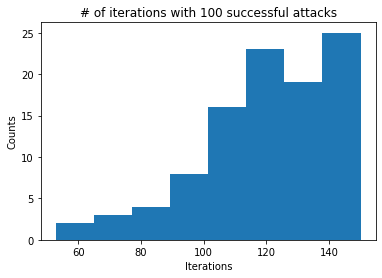

In [174]:
import matplotlib.pyplot as plt
_ = plt.hist(iterations, bins='auto')  # arguments are passed to np.histogram
plt.title(f"# of iterations with {len(iterations)} successful attacks")
plt.xlabel("Iterations")
plt.ylabel("Counts")
plt.show()

In [175]:
np.save('./Data/boundary_attack_iterations_100_samples_2.npy', np.array(iterations))

In [171]:
test = np.load('./Data/boundary_attack_iterations_100_samples.npy')
print(test.shape)

(100,)


In [144]:
# Statistics
file = open('./Data/boundary_attack_iteration_50_test_10000.txt',"r") 
texts = file.readlines()
file.close()

count = 0
for i in range(2, len(texts), 4):
    if int(texts[i]) == 1:
        count += 1
print(f"Success rate: {count * 1.0 / len(texts) * 4 * 100 : .4}%")

Success rate:  33.06%


In [141]:
len(texts) / 4

8950.0

In [14]:
def f():
    dict_attack_log = []
    for i in tqdm.tqdm_notebook(range(len(X_train_embed))):
        url, label = X_train_embed[i], int(Y_train[i].numpy()[0])
        if label == 1:
            log = Tensor_to_Log(symbol_dict, url)
            dict_attack_log.append(log)

In [23]:
def fin(i):
    tensor, label = X_train_embed[i], int(Y_train[i].numpy()[0])
    if label == 1:
        log = Tensor_to_Log(symbol_dict, tensor)
        return log, tensor
        
    return None

In [25]:
from multiprocessing import Pool
pool = Pool(8)

dict_attack_log_tensor = {}
for i,ret_msg in tqdm.tqdm_notebook(enumerate(pool.imap_unordered(fin,range(len(X_train_embed)))),total = len(X_train_embed)):
    #print(i)
    if ret_msg is not None:
        log, tensor = ret_msg
        dict_attack_log_tensor[log] = tensor


Process ForkPoolWorker-91:
Process ForkPoolWorker-93:
Process ForkPoolWorker-94:
Process ForkPoolWorker-96:
Traceback (most recent call last):
Process ForkPoolWorker-89:
Process ForkPoolWorker-90:
Process ForkPoolWorker-95:
Traceback (most recent call last):
Process ForkPoolWorker-92:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pepper/.conda/envs/torch/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/pepper/.conda/envs/torch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/pepper/.conda/envs/torch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/pepper/.conda/envs/torch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pepper/.conda/envs/torch/lib/python3.7/multiprocessing/process.py", line 297, in 

In [9]:
len(dict_attack_log)

17268

In [26]:
import difflib
def find_nearest_adversial(origins, candidate, distance_metric):
    dic = {}
    assert (len(candidate) > 0),"There should be at least one candidate"
    for i in tqdm.tqdm_notebook(origins):
        min_norm = None
        min_candidate = None
        for j in candidate:
            if min_norm is None:
                min_norm = distance_metric(i,j)
                min_candidate = j
            else:
                new_distance = distance_metric(i,j)
                min_norm, min_candidate = (min_norm, min_candidate) if new_distance > min_norm else (new_distance, j)
        dic[i] = min_candidate
    return dic
def str_similarity(str_a, str_b):
    #str_a = Tensor_to_Log(symbol_dict, tensor_a)
    #str_b = Tensor_to_Log(symbol_dict, tensor_b)
    return difflib.SequenceMatcher(a=str_a, b=str_b).ratio()

In [38]:
def nearest_tensor(X_test_embed):
    str_X_test = []
    for tensor in tqdm.tqdm_notebook(X_test_embed):
        str_X_test.append(Tensor_to_Log(symbol_dict, tensor))
    dict_nearest_str = find_nearest_adversial(str_X_test, dict_attack_log_tensor.keys(), str_similarity)

    X_test_nearest_tensor = []
    for log in str_X_test:
        X_test_nearest_tensor.append(dict_attack_log_tensor[dict_nearest_str[log]])
    return X_test_nearest_tensor

In [ ]:
X_test_nearest_tensor = nearest_tensor(X_test_embed)

In [18]:
Y_train.shape

torch.Size([42468, 1])

In [17]:
torch.sum(Y_train)

tensor(17268., dtype=torch.float64)

In [125]:
url[1]

array([-0.12354521,  0.48398593, -0.40627903,  0.6420066 , -0.41624388],
      dtype=float32)

In [126]:
adversarial[1]

array([-0.27464807,  0.49253538, -0.4223426 ,  0.44162118, -0.27377424],
      dtype=float32)